In [265]:
#!/usr/bin/env python3
'''
CasADi quadrotor simulation using low-fidelity controller
- Low-fidelity quadrotor model
- Simulation using CasADi
- Not translated from modelica version (hand-written)
'''

'\nCasADi quadrotor simulation using low-fidelity controller\n- Low-fidelity quadrotor model\n- Simulation using CasADi\n- Not translated from modelica version (hand-written)\n'

In [266]:
# import python packages
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy as sp

Utility functions

In [267]:
def eul2quat(euler):
    quat = ca.vertcat(ca.cos(euler[2]/2)*ca.cos(euler[1]/2)*ca.cos(euler[0]/2)+ca.sin(euler[2]/2)*ca.sin(euler[1]/2)*ca.sin(euler[0]/2),
                      ca.cos(euler[2]/2)*ca.cos(euler[1]/2)*ca.sin(euler[0]/2)-ca.sin(euler[2]/2)*ca.sin(euler[1]/2)*ca.cos(euler[0]/2),
                      ca.cos(euler[2]/2)*ca.sin(euler[1]/2)*ca.cos(euler[0]/2)+ca.sin(euler[2]/2)*ca.cos(euler[1]/2)*ca.sin(euler[0]/2),
                      ca.sin(euler[2]/2)*ca.cos(euler[1]/2)*ca.cos(euler[0]/2)-ca.cos(euler[2]/2)*ca.sin(euler[1]/2)*ca.sin(euler[0]/2))
    return quat

def quat2eul(quat):          
    euler = ca.vertcat(ca.atan2((2*quat[2]*quat[3]+2*quat[0]*quat[1]),(2*(quat[0]**2)+2*(quat[3]**2)-1)),
                       ca.asin(-(2*quat[1]*quat[3]-2*quat[0]*quat[2])),
                       ca.atan2((2*quat[1]*quat[2]+2*quat[0]*quat[3]),(2*(quat[0]**2)+2*(quat[1]**2)-1)))
    return euler

def quat2rot(quat):
    rot = ca.vertcat(ca.horzcat(1-2*(quat[2]*quat[2]+quat[3]*quat[3]), 2*(quat[1]*quat[2]-quat[0]*quat[3]), 2*(quat[1]*quat[3]+quat[0]*quat[2])),
				     ca.horzcat(2*(quat[1]*quat[2]+quat[0]*quat[3]), 1-2*(quat[1]*quat[1]+quat[3]*quat[3]), 2*(quat[2]*quat[3]-quat[0]*quat[1])),
				     ca.horzcat(2*(quat[1]*quat[3]-quat[0]*quat[2]), 2*(quat[2]*quat[3]+quat[0]*quat[1]), 1-2*(quat[1]*quat[1]+quat[2]*quat[2])))
    return rot

def quatinv(quat):
    inv_quat = ca.vertcat(quat[0], -quat[1], -quat[2], -quat[3])
    return inv_quat

def axang2quat(axis,angle):
    quat = ca.vertcat(ca.cos(0.5*angle),
                      axis[0]*ca.sin(0.5*angle),
                      axis[1]*ca.sin(0.5*angle),
                      axis[2]*ca.sin(0.5*angle))
    return quat

def quatmul(q,r):
    mul_quat = ca.vertcat(r[0]*q[0]-r[1]*q[1]-r[2]*q[2]-r[3]*q[3],
                          r[0]*q[1]+r[1]*q[0]-r[2]*q[3]+r[3]*q[2],
                          r[0]*q[2]+r[1]*q[3]+r[2]*q[0]-r[3]*q[1],
                          r[0]*q[3]-r[1]*q[2]+r[2]*q[1]+r[3]*q[0])
    return mul_quat

def normalballrand(ndim,R,nsample):

    u = np.random.rand(1,nsample)*sp.stats.chi2.cdf(R**2,ndim)
    r = sp.stats.chi2.ppf(u,ndim)
    X = np.random.randn(ndim,nsample)
    X = (r*X/np.linalg.norm(X,axis=0)).T
    
    return X

In [268]:
def if_else_builder(state, cond_branch):
    for i, (cond, branch) in enumerate(reversed(cond_branch)):
        state = ca.if_else(cond, branch, state)
    return state

Quadrotor Lo-Fi Model

In [269]:
def GS_quadrotor_LoFi():

	# parameters
	m = ca.SX.sym('m')
	Ixx = ca.SX.sym('Ixx')
	Iyy = ca.SX.sym('Iyy')
	Izz = ca.SX.sym('Izz')
	d_arm = ca.SX.sym('d_arm')
	r_dir = ca.SX.sym('r_dir',4)
	r_pos = ca.SX.sym('r_pos',4)
	c_m = ca.SX.sym('c_m')
	g = ca.SX.sym('g')

	p_vect = ca.vertcat(m, Ixx, Iyy, Izz, d_arm, r_dir, r_pos, c_m, g)

	# states
	xyz = ca.SX.sym('xyz',3)
	uvw = ca.SX.sym('uvx',3)
	quat = ca.SX.sym('quat',4)
	pqr = ca.SX.sym('pqr',3)

	x_vect = ca.vertcat(xyz, uvw, quat, pqr)

	# inputs
	F = ca.SX.sym('F',4)
	
	u_vect = ca.vertcat(F)

	# compute the rotation matrix from quaternion - defined as rotation from I to B
	R = quat2rot(quat)

	# get the inertia matrix
	J = ca.vertcat(ca.horzcat(Ixx, 0, 0),
				   ca.horzcat(0, Iyy, 0),
				   ca.horzcat(0, 0, Izz))
	
    # compute the thrust and moment
	T = -ca.sum1(F)
	M = ca.vertcat(-d_arm*(ca.sin(r_pos[0])*F[0]+ca.sin(r_pos[1])*F[1]+ca.sin(r_pos[2])*F[2]+ca.sin(r_pos[3])*F[3]),
                   d_arm*(ca.cos(r_pos[0])*F[0]+ca.cos(r_pos[1])*F[1]+ca.cos(r_pos[2])*F[2]+ca.cos(r_pos[3])*F[3]),
				   -c_m*(r_dir[0]*F[0]+r_dir[1]*F[1]+r_dir[2]*F[2]+r_dir[3]*F[3]))

	# differential equation
	xyz_dot = R@uvw
	uvw_dot = -ca.cross(pqr,uvw)+1/m*ca.vertcat(0,0,T)+R.T@ca.vertcat(0,0,g)
	quat_dot = 0.5*ca.vertcat(ca.horzcat(0, -pqr[0], -pqr[1], -pqr[2]),
                            ca.horzcat(pqr[0],  0,  pqr[2], -pqr[1]),
                            ca.horzcat(pqr[1], -pqr[2],  0,  pqr[0]),
                            ca.horzcat(pqr[2],  pqr[1], -pqr[0],  0))@quat
	pqr_dot = ca.inv_minor(J)@(-ca.cross(pqr,J@pqr)+M)
    
	dx_vect = ca.vertcat(xyz_dot, uvw_dot, quat_dot, pqr_dot)

	# define differential equation
	f = ca.Function('f', [x_vect, u_vect, p_vect], [dx_vect], ['x', 'u', 'p'], ['dx'])
	
	return f

Quadrotor Model Unit Test

In [270]:
# drone parameters can be obtained from sysID
# temporarily using the parameters obtained from 'rotorpy'
# S. Folk, J. Paulos, and V. Kumar, “RotorPy: A Python-based Multirotor Simulator 
# with Aerodynamics for Education and Research,” 2023. [1.325, 1.225, 1.225, 1.225]

f = GS_quadrotor_LoFi()
f([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [1.05329, 1.39671, 1.05329, 1.39671], [0.5, 3.65e-3, 3.68e-3, 7.03e-3, 0.17, 1, -1, 1, -1, 45/180*np.pi, 135/180*np.pi, 225/180*np.pi, 315/180*np.pi, (0.136e-06/5.570e-06), 9.8])

dt = 0.01
dae = {'x': f.sx_in(0), 'p': ca.vertcat(f.sx_in(1), f.sx_in(2)), 'ode': f(f.sx_in(0), f.sx_in(1), f.sx_in(2))}
integrator = ca.integrator('integrator', 'rk', dae, 0, dt)

result = integrator(x0=np.array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]), p=np.array([1.05329, 1.39671, 1.05329, 1.39671, 0.5, 3.65e-3, 3.68e-3, 7.03e-3, 0.17, 1, -1, 1, -1, 45/180*np.pi, 135/180*np.pi, 225/180*np.pi, 315/180*np.pi, (0.136e-06/5.570e-06), 9.8]))
print(result['xf'][0:6].full().flatten())
print(quat2eul(result['xf'][6:10]).full().flatten()/np.pi*180)

print(quat2rot(eul2quat(ca.vertcat(0, -20/180*np.pi, 0))).T@ca.vertcat(0, 0, 9.8))

[ 4.18847726e-23  1.61054586e-27  1.43211613e-41  1.67539090e-20
 -1.03202280e-24  0.00000000e+00]
[-6.80193929e-22 -2.93855595e-17  6.83402565e-03]
[3.3518, 0, 9.20899]


Controller Lo-Fi Model

In [271]:
def GS_controller_LoFi():

	# parameters
    ANGLE_MAX = ca.SX.sym('ANGLE_MAX')
    ANGLE_RATE_MAX = ca.SX.sym('ANGLE_RATE_MAX')
    ACC_MAX_Z = ca.SX.sym('ACC_MAX_Z')
    ANG_RLL_P = ca.SX.sym('ANG_RLL_P')
    ANG_PIT_P = ca.SX.sym('ANG_PIT_P')
    ANG_YAW_P = ca.SX.sym('ANG_YAW_P')
    RAT_RLL_P = ca.SX.sym('RAT_RLL_P')
    RAT_RLL_I = ca.SX.sym('RAT_RLL_I')
    RAT_RLL_D = ca.SX.sym('RAT_RLL_D')
    RAT_PIT_P = ca.SX.sym('RAT_PIT_P')
    RAT_PIT_I = ca.SX.sym('RAT_PIT_I')
    RAT_PIT_D = ca.SX.sym('RAT_PIT_D')
    RAT_YAW_P = ca.SX.sym('RAT_YAW_P')
    RAT_YAW_I = ca.SX.sym('RAT_YAW_I')
    RAT_YAW_D = ca.SX.sym('RAT_YAW_D')
    FREQ = ca.SX.sym('FREQ')
    MASS = ca.SX.sym('MASS')
    IXX = ca.SX.sym('IXX')
    IYY = ca.SX.sym('IYY')
    IZZ = ca.SX.sym('IZZ')
    D_ARM = ca.SX.sym('D_ARM')
    R_DIR = ca.SX.sym('R_DIR',4)
    R_POS = ca.SX.sym('R_POS',4)
    C_M = ca.SX.sym('C_M')

    p_vect = ca.vertcat(ANGLE_MAX, ANGLE_RATE_MAX, ACC_MAX_Z, ANG_RLL_P, ANG_PIT_P, ANG_YAW_P,
                        RAT_RLL_P, RAT_RLL_I, RAT_RLL_D, RAT_PIT_P, RAT_PIT_I, RAT_PIT_D, 
                        RAT_YAW_P, RAT_YAW_I, RAT_YAW_D, FREQ, MASS, IXX, IYY, IZZ, D_ARM, R_DIR, R_POS, C_M)

    # controller internal state (hybrid system)
    s = ca.SX.sym('s')
    yaw_target = ca.SX.sym('yaw_target')
    rate_err_last = ca.SX.sym('rate_err_last',3)
    rate_err_int = ca.SX.sym('rate_err_int',3)

    x_vect = ca.vertcat(s, yaw_target, rate_err_last, rate_err_int)

	# state feedback inputs
    xyz_fdbk = ca.SX.sym('xyz_fdbk',3)
    uvw_fdbk = ca.SX.sym('uvw_fdbk',3)
    quat_fdbk = ca.SX.sym('quat_fdbk',4)
    pqr_fdbk = ca.SX.sym('pqr_fdbk',3)
     
    u_vect = ca.vertcat(xyz_fdbk, uvw_fdbk, quat_fdbk, pqr_fdbk)

	# reference inputs
    normal_thr_cmd = ca.SX.sym('normal_thr_cmd')
    normal_roll_cmd = ca.SX.sym('normal_roll_cmd')
    normal_pitch_cmd = ca.SX.sym('normal_pitch_cmd')
    normal_yaw_rate_cmd = ca.SX.sym('normal_yaw_rate_cmd')

    r_vect = ca.vertcat(normal_thr_cmd, normal_roll_cmd, normal_pitch_cmd, normal_yaw_rate_cmd)

	# stick input conversion - add conversion between euler angle and roll/pitch angle
    acc_z_target = normal_thr_cmd*ACC_MAX_Z
    roll_target = normal_roll_cmd*ANGLE_MAX
    pitch_target = normal_pitch_cmd*ANGLE_MAX
    yaw_target_p = yaw_target+normal_yaw_rate_cmd*ANGLE_RATE_MAX
     
    # compute control command and update controller state (temp: no mode change in 's')   
    # attitude target given as the body angle seen from the inertial frame
    attitude_target = eul2quat(ca.vertcat(roll_target,pitch_target,yaw_target_p))

    # compute the desired thrust vector direction in inertial frame
    att_target_thrust_vec = quat2rot(quatinv(attitude_target))@ca.vertcat(0.0, 0.0, -1.0)

    # compute the current thrust vector direction in inertial frame
    att_body_thrust_vec = quat2rot(quatinv(quat_fdbk))@ca.vertcat(0.0, 0.0, -1.0)

    # compute the lean angle using the dot product
    thrust_angle = ca.acos(ca.fmax(ca.fmin(ca.dot(ca.vertcat(0.0, 0.0, -1.0),att_body_thrust_vec), 1), -1))

    # define the rotation vector using the cross product
    thrust_vec_cross_i1 = ca.cross(att_body_thrust_vec, att_target_thrust_vec)

    # compute the error angle between the target and desired thrust vector
    thrust_error_angle = ca.acos(ca.fmax(ca.fmin(ca.dot(att_body_thrust_vec, att_target_thrust_vec), 1), -1))

    # normalize the thrust rotation vector
    thrust_vec_cross_i2 = ca.if_else(ca.logic_or(ca.norm_2(thrust_vec_cross_i1) == 0, thrust_error_angle == 0), ca.vertcat(0, 0, -1), thrust_vec_cross_i1/ca.norm_2(thrust_vec_cross_i1))

    # transform the rotation vector back to body frame and compute roll/pitch error angle
    thrust_vec_cross_b = quat2rot(quat_fdbk)@thrust_vec_cross_i2
    thrust_vector_correction = axang2quat(thrust_vec_cross_b,thrust_error_angle)
    rp_error = quat2eul(thrust_vector_correction)

    # compute the heading error
    heading_vec_correction_quat = quatmul(quatinv(thrust_vector_correction),quatmul(quat_fdbk,quatinv(attitude_target)))
    y_error = quat2eul(heading_vec_correction_quat)

    # augment roll/pitch/yaw error and set target 
    att_err = ca.vertcat(rp_error[0], rp_error[1], y_error[2])
    rate_target = ca.vertcat(ANG_RLL_P, ANG_PIT_P, ANG_YAW_P)*att_err

    # compute the angular velocity error (differentiation/integration)
    rate_err = rate_target-pqr_fdbk

    rate_err_d = (rate_err-rate_err_last)*FREQ
    rate_err_last_p = rate_err
    rate_err_int_p = rate_err_int+rate_err/FREQ

    # compute target thrust
    force_target = MASS*(acc_z_target)/ca.cos(thrust_angle)

    # compute target moment
    J = ca.vertcat(ca.horzcat(IXX, 0, 0),
                   ca.horzcat(0, IYY, 0),
                   ca.horzcat(0, 0, IZZ))

    moment_target = J@(ca.vertcat(RAT_RLL_P, RAT_PIT_P, RAT_YAW_P)*rate_err+ca.vertcat(RAT_RLL_I, RAT_PIT_I, RAT_YAW_I)*rate_err_int_p+ca.vertcat(RAT_RLL_D, RAT_PIT_D, RAT_YAW_D)*rate_err_d+ca.cross(pqr_fdbk,J@pqr_fdbk))

    # update controller state (temp: no mode change in 's')   
    s_p = 0
    xp_vect = ca.vertcat(s_p, yaw_target_p, rate_err_last_p, rate_err_int_p)

    # update the controller output using control effectiveness
    CEM = ca.vertcat(ca.horzcat(1.0, 1.0, 1.0, 1.0),
                     ca.horzcat(D_ARM*ca.sin(R_POS[0]), D_ARM*ca.sin(R_POS[1]), D_ARM*ca.sin(R_POS[2]), D_ARM*ca.sin(R_POS[3])),
                     ca.horzcat(-D_ARM*ca.cos(R_POS[0]), -D_ARM*ca.cos(R_POS[1]), -D_ARM*ca.cos(R_POS[2]), -D_ARM*ca.cos(R_POS[3])),
                     ca.horzcat(C_M*R_DIR[0], C_M*R_DIR[1], C_M*R_DIR[2], C_M*R_DIR[3]))
    
    ctrl_out = ca.inv_minor(CEM)@ca.vertcat(force_target, moment_target)

    # algebraic equation
    c = ca.Function('c', [x_vect, u_vect, r_vect, p_vect], [xp_vect, ctrl_out], ['x', 'u', 'r', 'p'], ['xp', 'y'])

    return c



Controller Model Unit Test

In [272]:
c = GS_controller_LoFi()
c([0, 1/180*np.pi, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0.5, 0.0, 0.0, 0.0], 
  [30/180*np.pi, 60/180*np.pi, 2*9.8, 4.4, 4.4, 3.4, 0.12, 0.012, 0.24, 0.12, 0.012, 0.24, 0.20, 0.02, 0.40, 100, 
   0.5, 3.65e-3, 3.68e-3, 7.03e-3, 0.17, 1, -1, 1, -1, 45/180*np.pi, 135/180*np.pi, 225/180*np.pi, 315/180*np.pi, (0.136e-06/5.570e-06)])



(DM([0, 0.0174533, 0, 0, -0.0593412, 0, 0, -0.000593412]),
 DM([1.05329, 1.39671, 1.05329, 1.39671]))

Simulation

In [286]:
def simulate(t0, tf, dt, joystick_cmd_hist, gyro_dist_rnd = np.zeros((int((tf-t0)/dt)+1,3))):
    
    # initialize controller state
    s0 = np.array([0, 0, 0, 0, 0, 0, 0, 0])

    # initialize vehicle state
    x0 = np.array([0, 0, 0, 0, 0, 0, 1.0, 0.0, 0.0, 0.0, 0, 0, 0])

    # initialize control input
    u0 = np.array([1.225, 1.225, 1.225, 1.225])

    # initialize dynamics parameters
    quad_params = np.array([0.5, 3.65e-3, 3.68e-3, 7.03e-3, 0.17, 1, -1, 1, -1, 45/180*np.pi, 135/180*np.pi, 225/180*np.pi, 315/180*np.pi, (0.136e-06/5.570e-06), 9.8])

    # initialize controller parameters
    ctrl_params = np.array([30/180*np.pi, 60/180*np.pi, 2*9.8, 4.4, 4.4, 3.4, 0.12, 0.012, 0.24, 0.12, 0.012, 0.24, 0.20, 0.02, 0.40, 1/dt, 
    0.5, 3.65e-3, 3.68e-3, 7.03e-3, 0.17, 1, -1, 1, -1, 45/180*np.pi, 135/180*np.pi, 225/180*np.pi, 315/180*np.pi, (0.136e-06/5.570e-06)])

    # initialize simulation log
    sim = {'s': np.empty((int((tf-t0)/dt)+1,s0.size)), 'x': np.empty((int((tf-t0)/dt)+1,x0.size)), 'u': np.empty((int((tf-t0)/dt),u0.size)), 'r': np.empty((int((tf-t0)/dt),joystick_cmd_hist[0].size)), 't': np.empty((int((tf-t0)/dt)))}
    sim['s'][0,:] = s0
    sim['x'][0,:] = x0

    # initialize quadrotor and controller
    f = GS_quadrotor_LoFi()
    c = GS_controller_LoFi()
    dae = {'x': f.sx_in(0), 'p': ca.vertcat(f.sx_in(1), f.sx_in(2)), 'ode': f(f.sx_in(0), f.sx_in(1), f.sx_in(2))}
    integrator = ca.integrator('integrator', 'rk', dae, 0, dt)

    # run simulation
    t = np.linspace(t0, tf, int((tf-t0)/dt)+1)
    for idx, t_idx in enumerate(t[0:-1]):

        x_ultrasound = sim['x'][idx,:]+np.hstack((np.zeros(10),np.array(gyro_dist_rnd[idx,:])))
        [s_temp, u_temp] = c(sim['s'][idx,:], x_ultrasound, joystick_cmd_hist[idx,:], ctrl_params)
        sim['s'][idx+1,:] = s_temp.toarray().flatten()
        sim['u'][idx,:] = u_temp.toarray().flatten()
        sim['r'][idx,:] = joystick_cmd_hist[idx,:]
        sim['t'][idx] = t_idx
        int_temp = integrator(x0=sim['x'][idx,:], p=np.hstack((u_temp.toarray().flatten(),quad_params)))
        sim['x'][idx+1,:] = int_temp['xf'].full().flatten()

    return sim

Final Distance: 10.883576086469288


Text(0, 0.5, 'RATE [deg/s]')

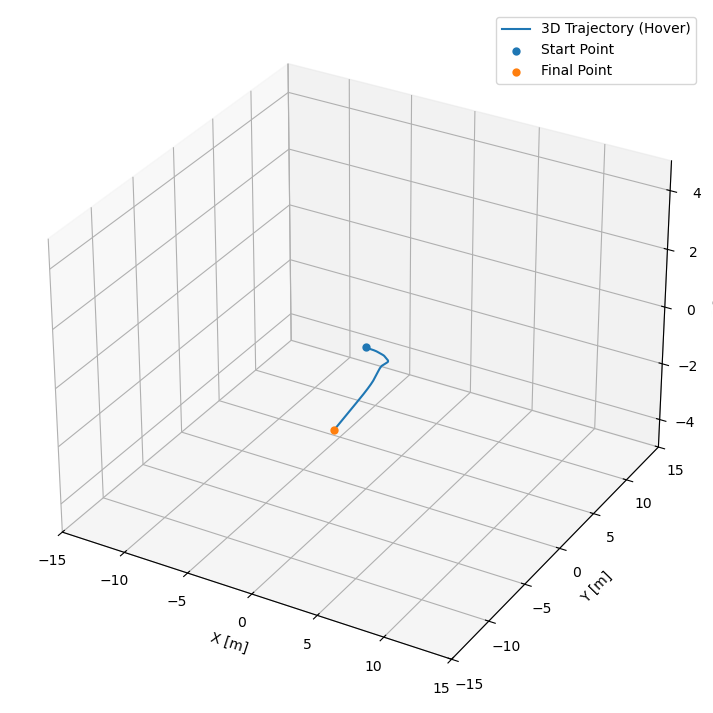

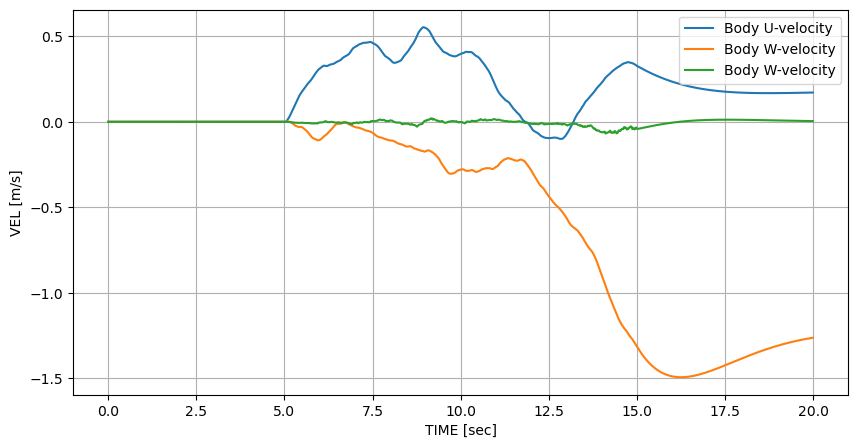

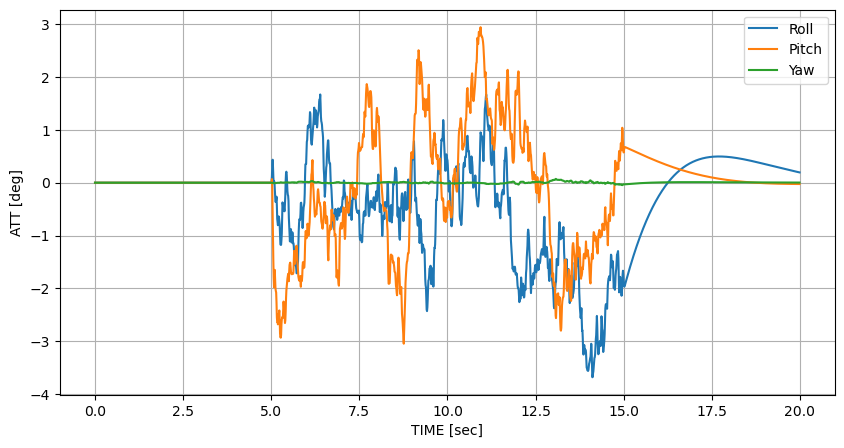

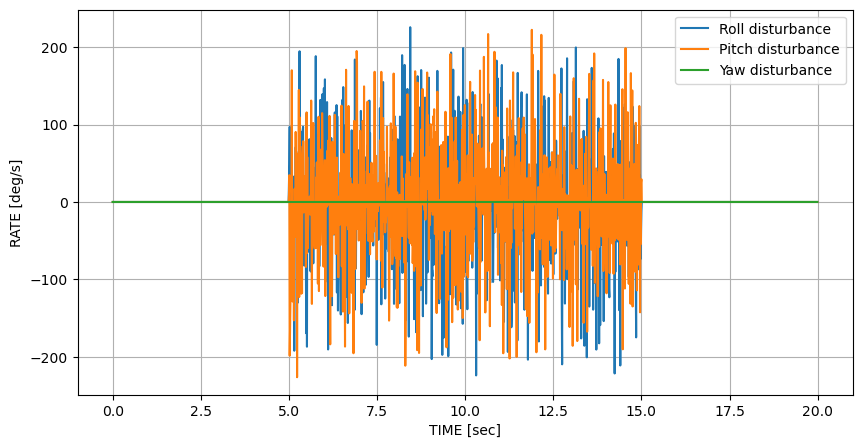

In [ ]:
# simulation under distrubances given to gyroscope by ultrasound (simple)
t0 = 0.0
tf = 20.0
dt = 0.01 

# hover simulation
joystick_cmd_h = np.zeros((int((tf-t0)/dt)+1,4))
joystick_cmd_h[:,0] = 0.5

# create the random gyro disturbance
gyro_dist_rnd = np.zeros((int((tf-t0)/dt)+1,3))
td0 = 5.0
tdf = 15.0
d_axis = [0,1]
d_level = 2.0
gyro_dist_rnd[int(td0/dt):int(tdf/dt)+1,d_axis] = normalballrand(len(d_axis),d_level,int((tdf-td0)/dt)+1)

sim_log_hover = simulate(t0, tf, dt, joystick_cmd_h, gyro_dist_rnd)

sim_log_hover_rpy = np.zeros((int((tf-t0)/dt)+1,3))
for idx in range(int((tf-t0)/dt)+1):
    sim_log_hover_rpy[idx] = quat2eul(sim_log_hover['x'][idx,6:10]).toarray().flatten()/np.pi*180

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.plot(sim_log_hover['x'][:,0], sim_log_hover['x'][:,1], -sim_log_hover['x'][:,2], linestyle='-', linewidth=1.5, label='3D Trajectory (Hover)')
ax.scatter(sim_log_hover['x'][0,0], sim_log_hover['x'][0,1], -sim_log_hover['x'][0,2], marker='o', linewidth=1.5, label='Start Point')
ax.scatter(sim_log_hover['x'][-1,0], sim_log_hover['x'][-1,1], -sim_log_hover['x'][-1,2], marker='o', linewidth=1.5, label='End Point')
ax.legend()
ax.set_xlim(-15.0, 15.0)
ax.set_ylim(-15.0, 15.0)
ax.set_zlim(-5.0, 5.0)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
print("Final Distance: {}".format(np.sqrt(sim_log_hover['x'][-1,0]**2+sim_log_hover['x'][-1,1]**2)))

plt.figure(figsize=(10, 5))
plt.plot(sim_log_hover['t'],sim_log_hover['x'][:-1,3],label='Body U-velocity')
plt.plot(sim_log_hover['t'],sim_log_hover['x'][:-1,4],label='Body W-velocity')
plt.plot(sim_log_hover['t'],sim_log_hover['x'][:-1,5],label='Body W-velocity')
plt.legend()
plt.grid()
plt.xlabel('TIME [sec]')
plt.ylabel('VEL [m/s]')

plt.figure(figsize=(10, 5))
plt.plot(sim_log_hover['t'],sim_log_hover_rpy[:-1,0],label='Roll')
plt.plot(sim_log_hover['t'],sim_log_hover_rpy[:-1,1],label='Pitch')
plt.plot(sim_log_hover['t'],sim_log_hover_rpy[:-1,2],label='Yaw')
plt.legend()
plt.grid()
plt.xlabel('TIME [sec]')
plt.ylabel('ATT [deg]')

plt.figure(figsize=(10, 5))
plt.plot(sim_log_hover['t'],gyro_dist_rnd[:-1,0]/np.pi*180,label='Roll disturbance')
plt.plot(sim_log_hover['t'],gyro_dist_rnd[:-1,1]/np.pi*180,label='Pitch disturbance')
plt.plot(sim_log_hover['t'],gyro_dist_rnd[:-1,2]/np.pi*180,label='Yaw disturbance')
plt.legend()
plt.grid()
plt.xlabel('TIME [sec]')
plt.ylabel('RATE [deg/s]')

Text(0, 0.5, 'ATT [deg]')

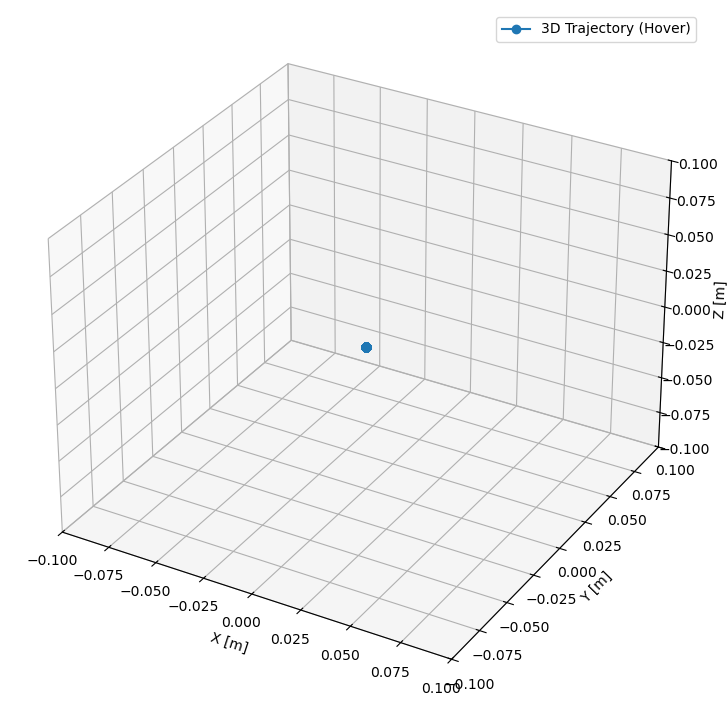

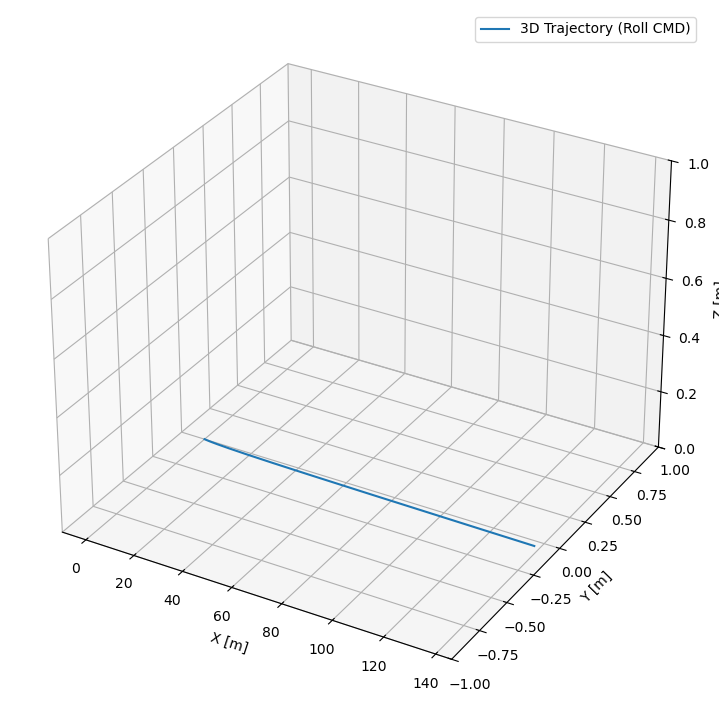

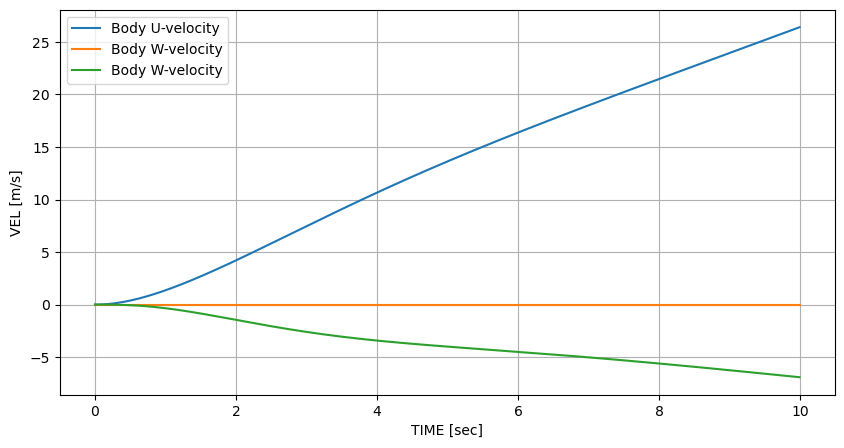

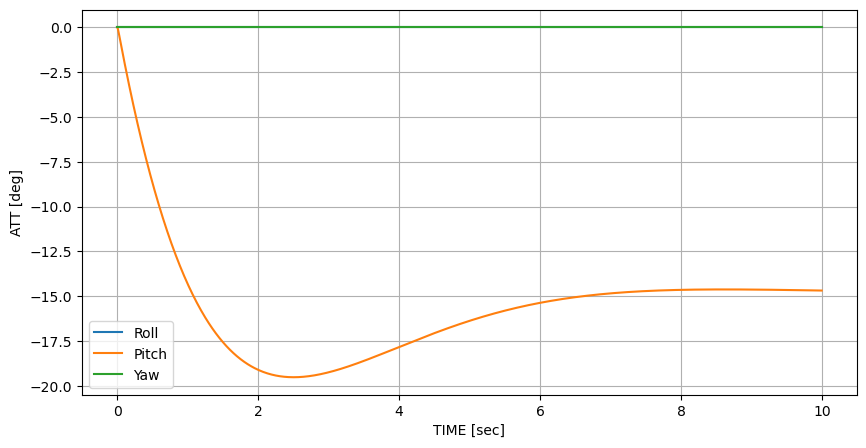

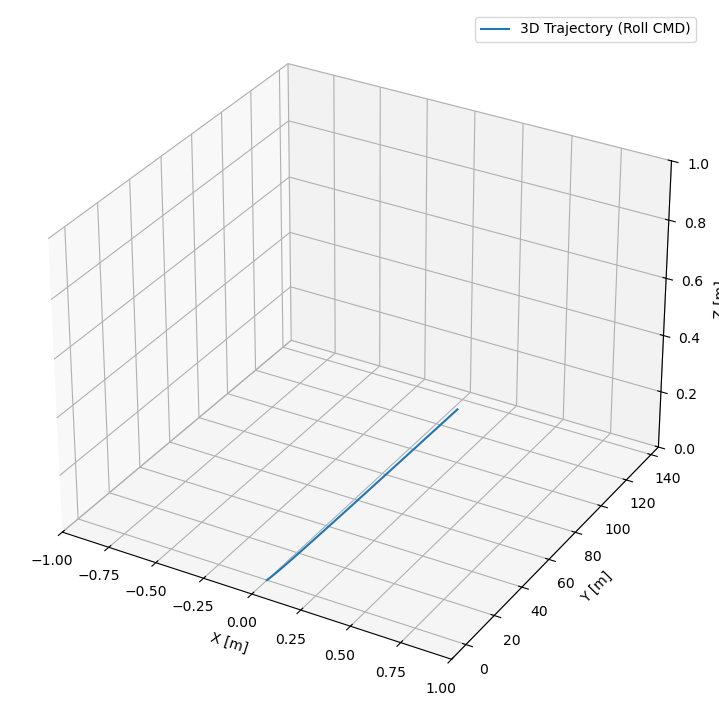

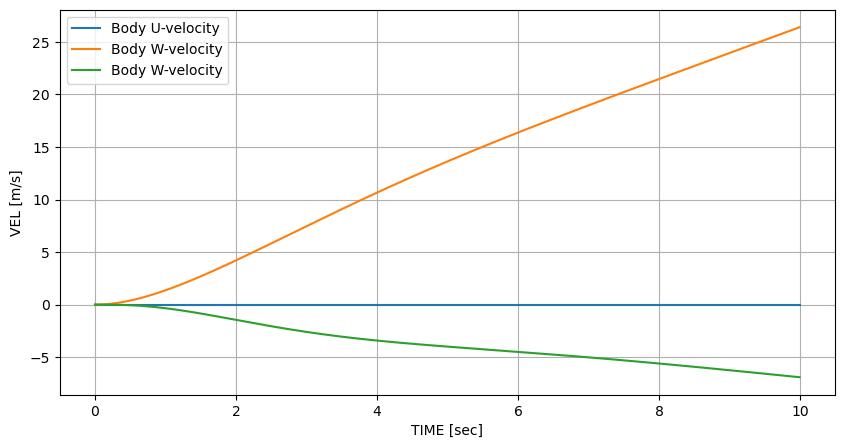

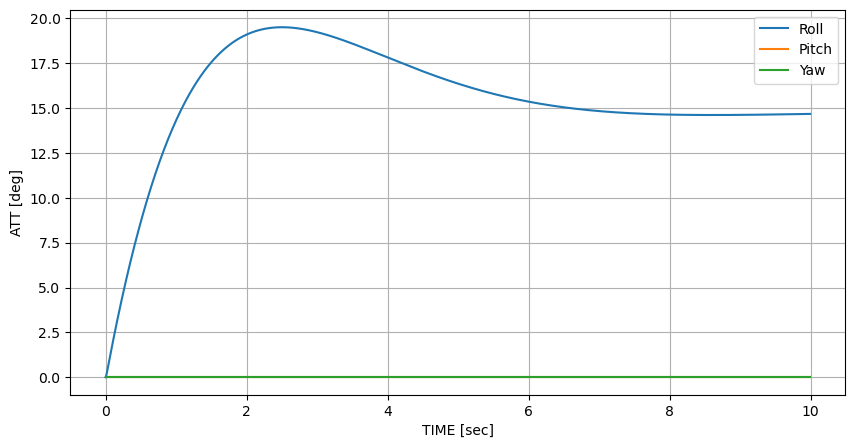

In [ ]:
# simulations using different joystick command history
t0 = 0.0
tf = 10.0
dt = 0.01 

# hover simulation
joystick_cmd_h = np.zeros((int((tf-t0)/dt)+1,4))
joystick_cmd_h[:,0] = 0.5
joystick_cmd_h[:,1] = 0.0

sim_log_hover = simulate(t0, tf, dt, joystick_cmd_h)

sim_log_hover_rpy = np.zeros((int((tf-t0)/dt)+1,3))
for idx in range(int((tf-t0)/dt)+1):
    sim_log_hover_rpy[idx] = quat2eul(sim_log_hover['x'][idx,6:10]).toarray().flatten()

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.plot(sim_log_hover['x'][:,0], sim_log_hover['x'][:,1], -sim_log_hover['x'][:,2], marker='o', linestyle='-', linewidth=1.5, label='3D Trajectory (Hover)')
ax.legend()
ax.set_xlim(-0.1, 0.1)
ax.set_ylim(-0.1, 0.1)
ax.set_zlim(-0.1, 0.1)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')

# pitch -15deg simulation
joystick_cmd_p = np.zeros((int((tf-t0)/dt)+1,4))
joystick_cmd_p[:,0] = 0.5
joystick_cmd_p[:,2] = -0.5

sim_log_pit = simulate(t0, tf, dt, joystick_cmd_p)

sim_log_pit_rpy = np.zeros((int((tf-t0)/dt)+1,3))
for idx in range(int((tf-t0)/dt)+1):
    sim_log_pit_rpy[idx] = quat2eul(sim_log_pit['x'][idx,6:10]).toarray().flatten()/np.pi*180

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.plot(sim_log_pit['x'][:,0], sim_log_pit['x'][:,1], -sim_log_pit['x'][:,2], linestyle='-', linewidth=1.5, label='3D Trajectory (Roll CMD)')
ax.legend()
ax.set_ylim(-1.0, 1.0)
ax.set_zlim(0.0, 1.0)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')

plt.figure(figsize=(10, 5))
plt.plot(sim_log_pit['t'],sim_log_pit['x'][:-1,3],label='Body U-velocity')
plt.plot(sim_log_pit['t'],sim_log_pit['x'][:-1,4],label='Body W-velocity')
plt.plot(sim_log_pit['t'],sim_log_pit['x'][:-1,5],label='Body W-velocity')
plt.legend()
plt.grid()
plt.xlabel('TIME [sec]')
plt.ylabel('VEL [m/s]')

plt.figure(figsize=(10, 5))
plt.plot(sim_log_pit['t'],sim_log_pit_rpy[:-1,0],label='Roll')
plt.plot(sim_log_pit['t'],sim_log_pit_rpy[:-1,1],label='Pitch')
plt.plot(sim_log_pit['t'],sim_log_pit_rpy[:-1,2],label='Yaw')
plt.legend()
plt.grid()
plt.xlabel('TIME [sec]')
plt.ylabel('ATT [deg]')

# roll 15deg simulation
joystick_cmd_r = np.zeros((int((tf-t0)/dt)+1,4))
joystick_cmd_r[:,0] = 0.5
joystick_cmd_r[:,1] = 0.5

sim_log_rll = simulate(t0, tf, dt, joystick_cmd_r)

sim_log_rll_rpy = np.zeros((int((tf-t0)/dt)+1,3))
for idx in range(int((tf-t0)/dt)+1):
    sim_log_rll_rpy[idx] = quat2eul(sim_log_rll['x'][idx,6:10]).toarray().flatten()/np.pi*180

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.plot(sim_log_rll['x'][:,0], sim_log_rll['x'][:,1], -sim_log_rll['x'][:,2], linestyle='-', linewidth=1.5, label='3D Trajectory (Roll CMD)')
ax.legend()
ax.set_xlim(-1.0, 1.0)
ax.set_zlim(0.0, 1.0)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')

plt.figure(figsize=(10, 5))
plt.plot(sim_log_rll['t'],sim_log_rll['x'][:-1,3],label='Body U-velocity')
plt.plot(sim_log_rll['t'],sim_log_rll['x'][:-1,4],label='Body W-velocity')
plt.plot(sim_log_rll['t'],sim_log_rll['x'][:-1,5],label='Body W-velocity')
plt.legend()
plt.grid()
plt.xlabel('TIME [sec]')
plt.ylabel('VEL [m/s]')

plt.figure(figsize=(10, 5))
plt.plot(sim_log_rll['t'],sim_log_rll_rpy[:-1,0],label='Roll')
plt.plot(sim_log_rll['t'],sim_log_rll_rpy[:-1,1],label='Pitch')
plt.plot(sim_log_rll['t'],sim_log_rll_rpy[:-1,2],label='Yaw')
plt.legend()
plt.grid()
plt.xlabel('TIME [sec]')
plt.ylabel('ATT [deg]')